# NASUnet: LBT

In [1]:
from base.get_data import generate_cell_data

#generate_cell_data()

In [2]:
import pickle

genotype = pickle.load( open( "lbt_genotype.pkl", "rb" ) )

In [3]:
import torch
from lbt.search.backbone import model_search
from base import gpu_test

device = gpu_test.get_device()
device.type

Using device: cuda

GeForce RTX 3070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


'cuda'

In [8]:
import matplotlib.pyplot as plt

def plot(true_values, predicted_values, title):
    """Plot true vs predicted counts and loss."""
   

    fig = plt.figure()
    plt.scatter(true_values, predicted_values)

    plt.title(title)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.show()
    

# Training NasUNet from Genotype

In [5]:
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tqdm.autonotebook import tqdm

def train_nas(train_queue, model_nas, criterion_nas, optimizer):
    print("Training: ")
    true_values = []
    predicted_values = []
    loss_vals = []
    
    for image, label in tqdm(train_queue):

        model_nas.train()

        image = image.cuda()
        label = label.cuda()

        optimizer.zero_grad()

        logits = model_nas(image)
                
        if isinstance(logits, list):
            loss = criterion_nas(logits[0], label)
        else:
            loss = criterion_nas(logits, label)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)
        optimizer.step()
        loss_vals.append(loss.item())

        for true, predicted in zip(label, logits):

            true_counts = torch.sum(true).item() / 100
            predicted_counts = torch.sum(predicted).item() / 100

            # update current epoch results
            true_values.append(true_counts)
            predicted_values.append(predicted_counts)

    
    print("Mean Loss: ", mean(loss_vals))
    print("MAE: ", mean_absolute_error(true_values, predicted_values))
    print("MSE: ", mean_squared_error(true_values, predicted_values))
    plot(true_values, predicted_values, "Train")



def validate_nas(valid_queue, model_nas, criterion_nas):
    
    print("Validation: ")
    
    true_values = []
    predicted_values = []
    loss_vals = []
    
    for image, label in tqdm(valid_queue):
        image = Variable(image, volatile=True).cuda()
        label = Variable(label, volatile=True).cuda()
        
        logits = model_nas(image)
            
        if isinstance(logits, list):
            loss = criterion_nas(logits[0], label)
        else:
            loss = criterion_nas(logits, label)
        
        loss_vals.append(loss.item())
        
        for true, predicted in zip(label, logits):

            true_counts = torch.sum(true).item() / 100
            predicted_counts = torch.sum(predicted).item() / 100

            # update current epoch results
            true_values.append(true_counts)
            predicted_values.append(predicted_counts)
        
    
    print("Mean Loss: ", mean(loss_vals))
    print("MAE: ", mean_absolute_error(true_values, predicted_values))
    print("MSE: ", mean_squared_error(true_values, predicted_values))
    plot(true_values, predicted_values, "Validation")

In [9]:
from lbt.models import nas_unet
from base import data_loader
from base import train
from torch.autograd import Variable

data_loader = train.get_loader('cell', batch_size=1, horizontal_flip = 0.5, vertical_flip = 0.5)

train_queue = data_loader['train']
valid_queue = data_loader['valid']

criterion_nas = torch.nn.MSELoss()
criterion_nas = criterion_nas.cuda()

model_nas = nas_unet.NasUnet(1, 3, aux = False, genotype = genotype)
model_nas = model_nas.cuda()

optimizer_nas = torch.optim.SGD(
      model_nas.parameters(),
      0.025,
      momentum=0.9,
      weight_decay=3e-4)

This model does not need pretrained backbone


Epoch:  0
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  2.1555969389279683
MAE:  135.6973819864909
MSE:  43834.47456168384


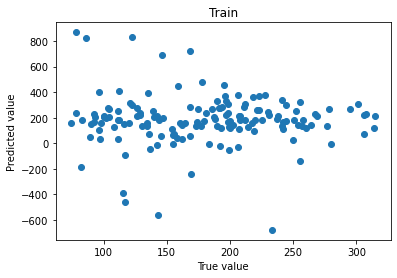

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.7692734122276306
MAE:  72.05758896484375
MSE:  6780.135130329672


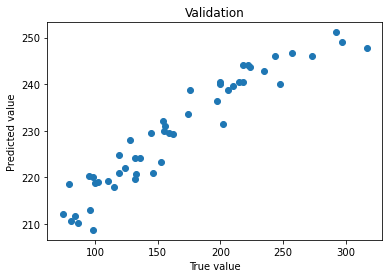

Epoch:  1
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.7240556371212006
MAE:  56.15155927734374
MSE:  4748.843942081361


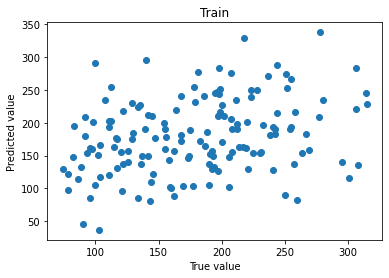

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.4992125618457794
MAE:  70.4389453125
MSE:  7149.035123973961


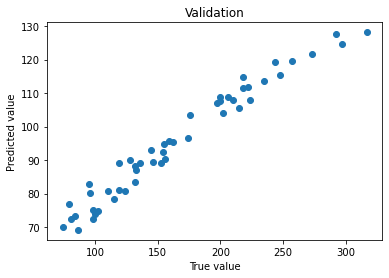

Epoch:  2
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.613091648419698
MAE:  62.75825100911459
MSE:  6037.921720485863


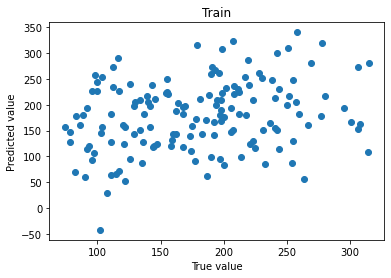

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.3433568453788758
MAE:  90.00952202148437
MSE:  9427.684421761305


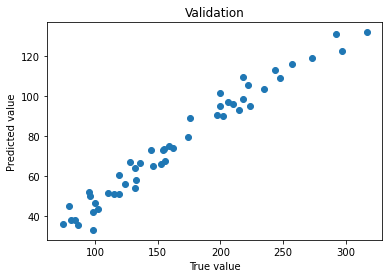

Epoch:  3
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.474312250216802
MAE:  48.390860286458334
MSE:  3604.644126621324


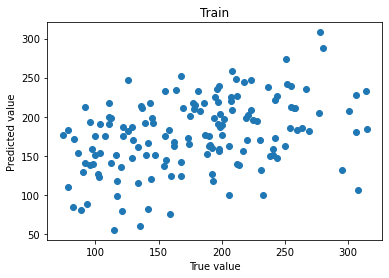

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.2666656464338302
MAE:  42.588442675781245
MSE:  3123.8501796740306


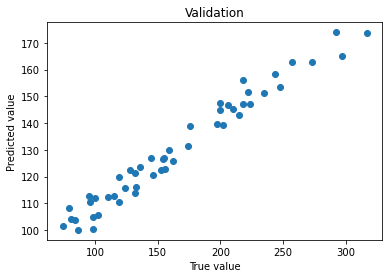

Epoch:  4
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.444607736269633
MAE:  49.21499736328125
MSE:  3841.8166373611707


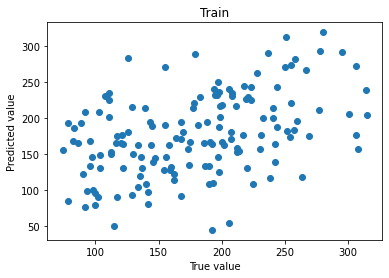

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.271945706009865
MAE:  30.788208691406254
MSE:  1355.504698703053


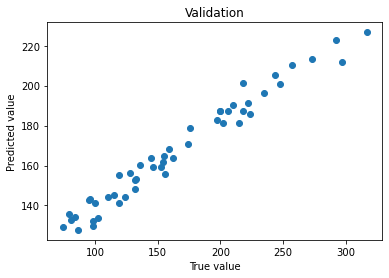

Epoch:  5
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.3782342171669006
MAE:  37.758138671874995
MSE:  2221.1896770181716


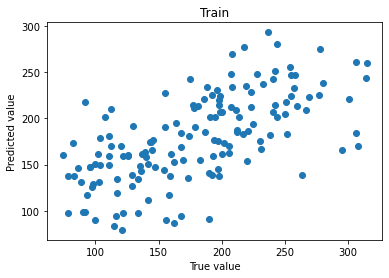

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.2644482553005219
MAE:  34.797834765625
MSE:  1838.7044316495678


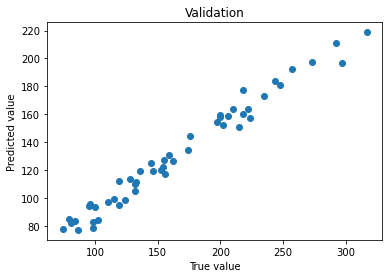

Epoch:  6
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.3292052584886551
MAE:  30.248546191406252
MSE:  1402.8659934501322


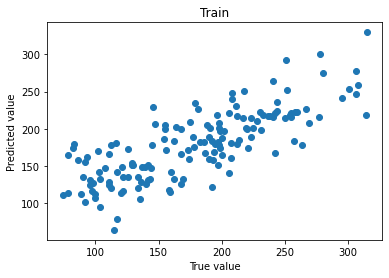

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.115842797756195
MAE:  28.148414941406248
MSE:  1000.5446557587019


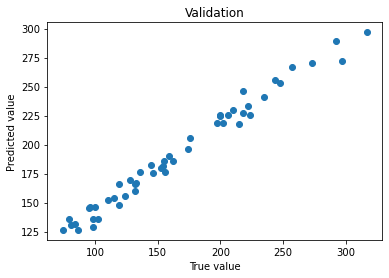

Epoch:  7
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.313385294675827
MAE:  33.78189436848958
MSE:  1820.5194554739485


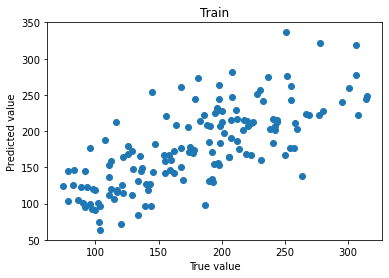

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.2127493959665299
MAE:  21.918053222656248
MSE:  784.9103903652004


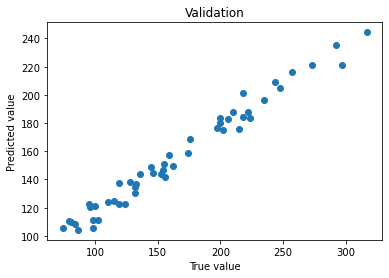

Epoch:  8
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2928582415978114
MAE:  27.658854199218755
MSE:  1164.6358096720342


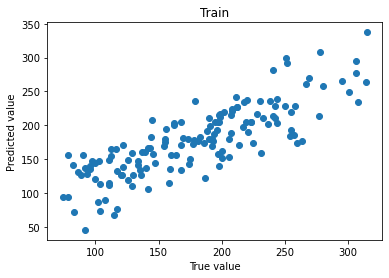

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.4698019862174987
MAE:  43.403248730468746
MSE:  2249.708983544842


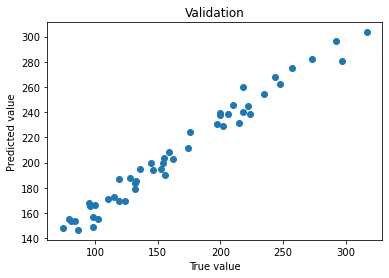

Epoch:  9
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2782918737332025
MAE:  26.314765690104164
MSE:  1140.2499595854654


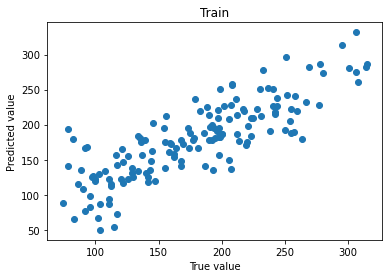

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.5085943305492402
MAE:  13.397107910156246
MSE:  272.12867411764387


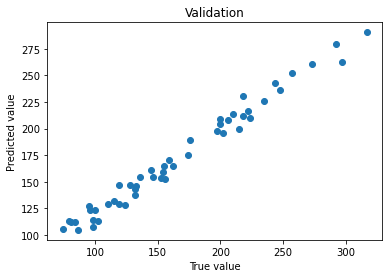

Epoch:  10
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2544453338781993
MAE:  20.872332031249996
MSE:  706.5662094404361


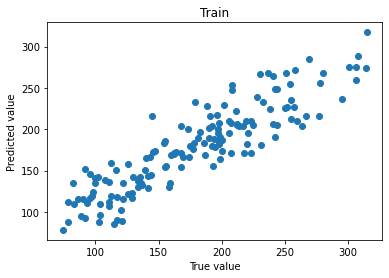

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.3644609701633454
MAE:  11.094857714843751
MSE:  208.10319249153758


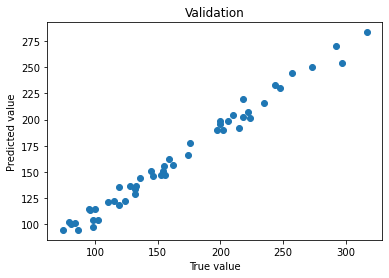

Epoch:  11
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.222404911716779
MAE:  22.396765917968747
MSE:  789.4000121551617


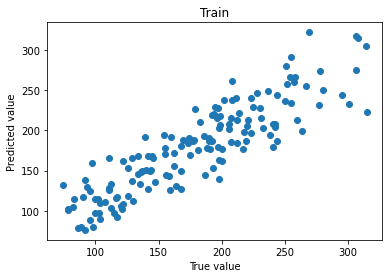

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1962000864744187
MAE:  20.39173701171875
MSE:  516.5158078318753


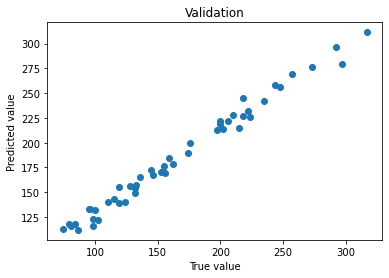

Epoch:  12
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.22320516705513
MAE:  20.845779524739584
MSE:  668.9917287403292


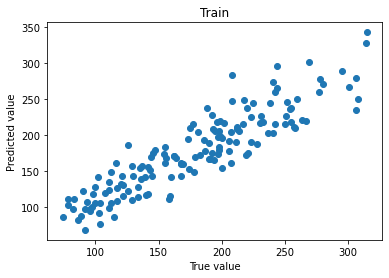

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0334654611349106
MAE:  18.76263076171875
MSE:  466.06829962335064


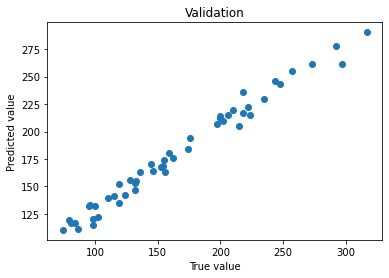

Epoch:  13
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.224177549680074
MAE:  21.449577539062503
MSE:  684.5000003651994


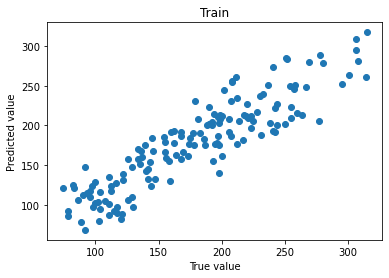

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.2914999783039094
MAE:  7.146662402343752
MSE:  90.31067154423765


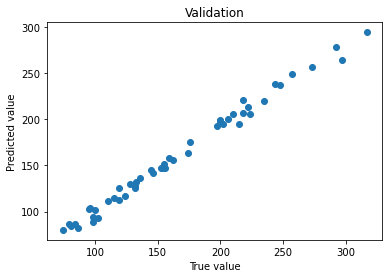

Epoch:  14
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1896906858682632
MAE:  17.478713997395833
MSE:  459.91215183728434


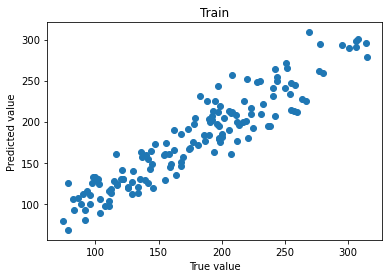

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0432527893781662
MAE:  14.120732324218752
MSE:  251.87449865683797


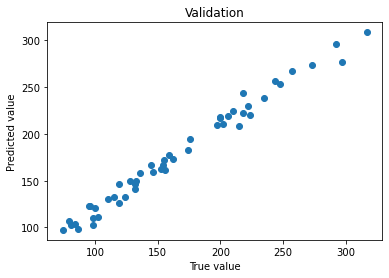

Epoch:  15
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2068892949819565
MAE:  20.44551653645833
MSE:  702.6488972270918


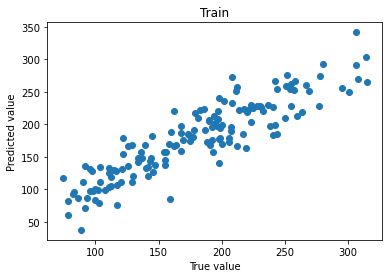

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0775154465436936
MAE:  9.91856025390625
MSE:  172.23824909833954


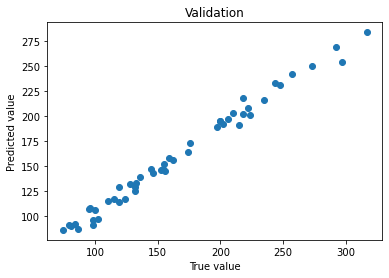

Epoch:  16
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2066526075204214
MAE:  20.42403893229167
MSE:  644.4223229026028


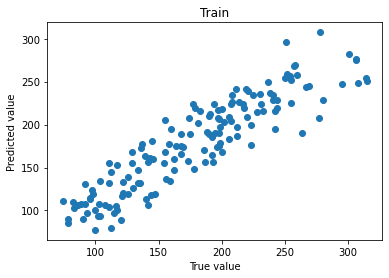

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1788089084625244
MAE:  39.89417622070312
MSE:  1628.354818444278


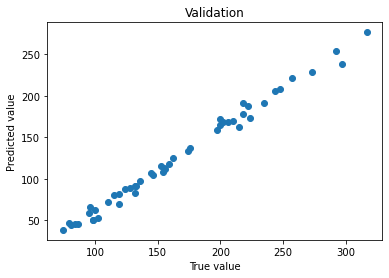

Epoch:  17
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.2176501129070918
MAE:  21.62572395833333
MSE:  707.9530469309055


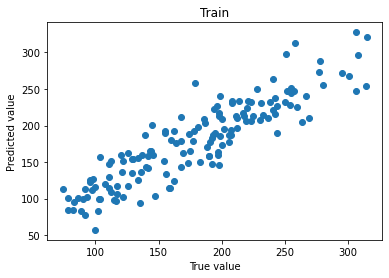

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.058185642361641
MAE:  12.20067578125
MSE:  195.04424183813956


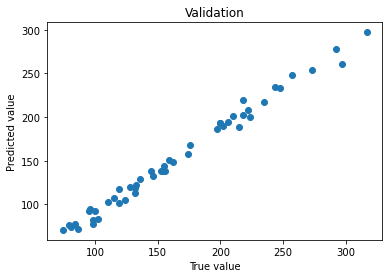

Epoch:  18
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1682048261165618
MAE:  16.382418489583333
MSE:  428.9522166846403


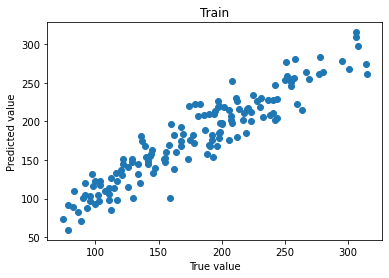

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1562764537334442
MAE:  7.309026562500001
MSE:  86.67775164237499


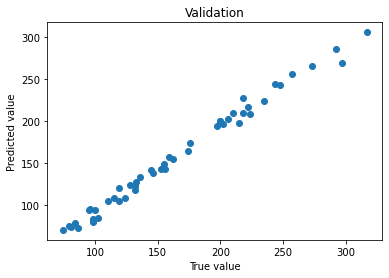

Epoch:  19
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1542882633209228
MAE:  16.331949902343748
MSE:  427.80341784773907


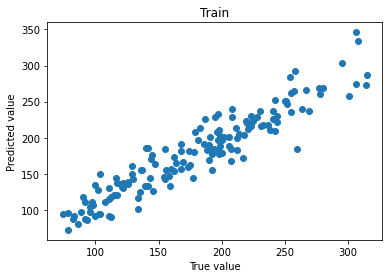

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1007503712177276
MAE:  5.19345087890625
MSE:  44.44909620150039


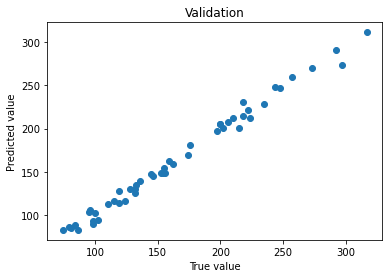

Epoch:  20
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1462105363607407
MAE:  14.029063671874997
MSE:  311.5098684746215


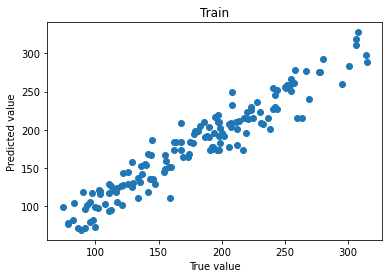

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9322164064645767
MAE:  15.305691503906253
MSE:  266.38136808317233


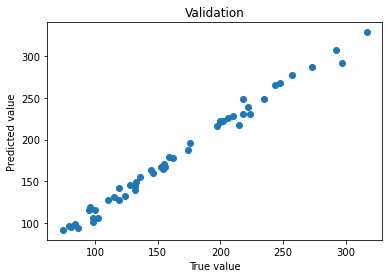

Epoch:  21
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.166040957570076
MAE:  16.49615709635417
MSE:  404.27645870631824


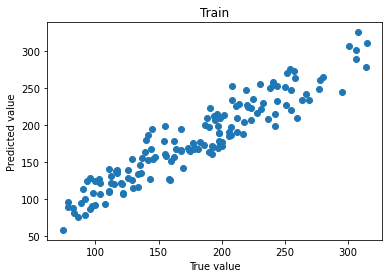

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9678202146291732
MAE:  5.429170214843748
MSE:  52.69091411685988


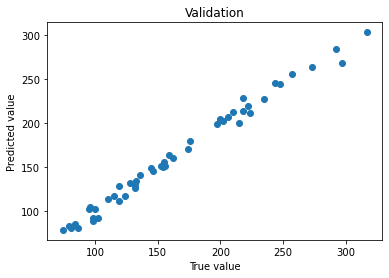

Epoch:  22
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1627636682987212
MAE:  15.659127669270832
MSE:  352.39452031793246


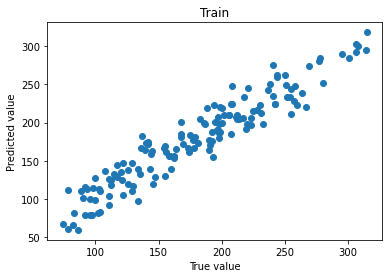

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0038923728466034
MAE:  10.298576562500003
MSE:  183.12904333162402


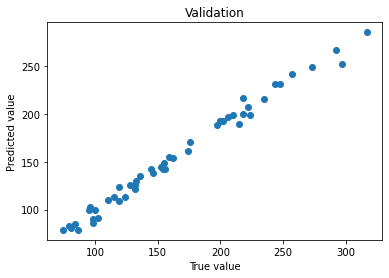

Epoch:  23
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1455228606859842
MAE:  17.423751236979168
MSE:  461.3895005068319


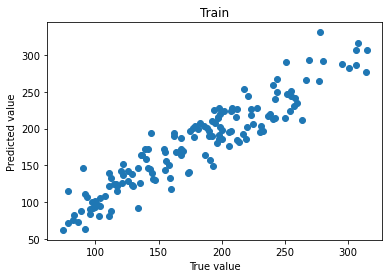

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8877486371994019
MAE:  5.78127001953125
MSE:  67.26956692110967


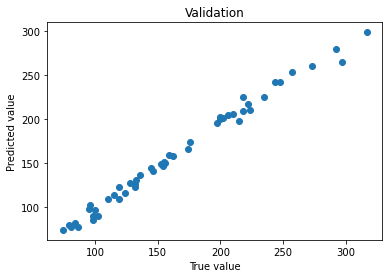

Epoch:  24
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1316700279712677
MAE:  12.617271223958333
MSE:  260.5912776237173


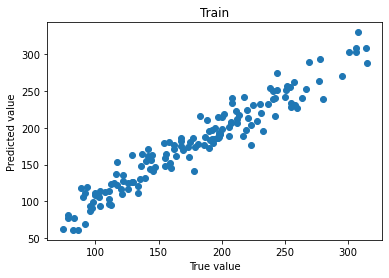

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8773405998945236
MAE:  17.681627636718748
MSE:  354.0009509771391


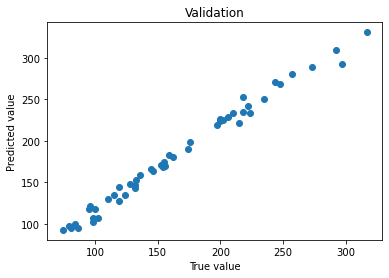

Epoch:  25
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1444991125663122
MAE:  18.42835693359375
MSE:  580.3626707005827


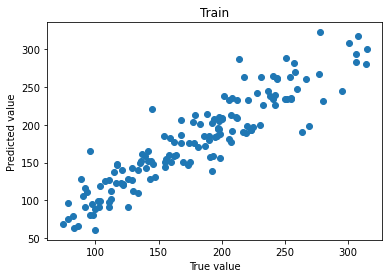

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9002348893880844
MAE:  13.15622880859375
MSE:  203.51798318424468


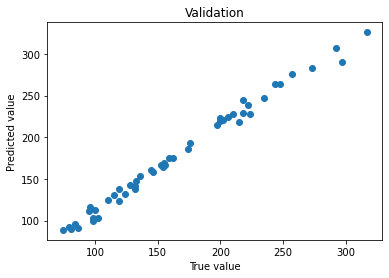

Epoch:  26
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1560384029150008
MAE:  16.810585774739586
MSE:  444.38361742979896


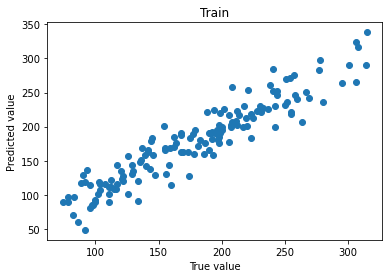

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0373323142528534
MAE:  6.438681933593751
MSE:  73.42898021369791


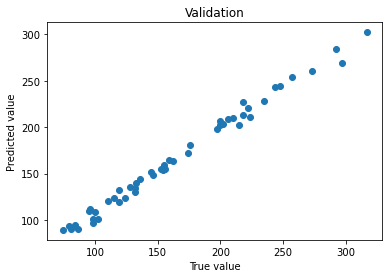

Epoch:  27
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1374556974569956
MAE:  22.882757975260418
MSE:  809.9387935139404


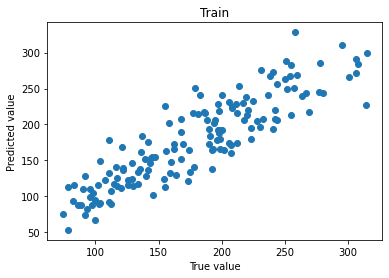

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9261866629123687
MAE:  9.7380306640625
MSE:  136.81698001762098


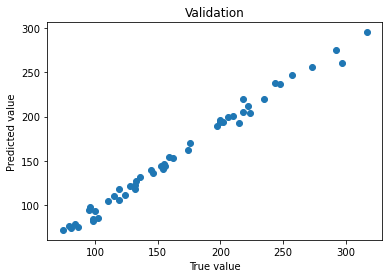

Epoch:  28
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1315795161326727
MAE:  15.193626139322914
MSE:  347.41494160548444


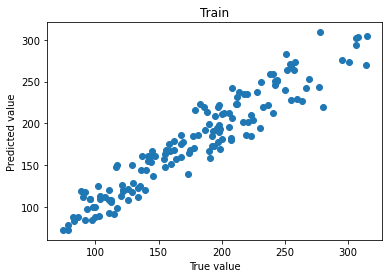

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0568998408317567
MAE:  6.240344628906252
MSE:  70.77396365482382


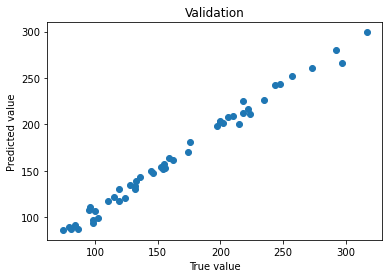

Epoch:  29
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1385660684108734
MAE:  17.176321158854165
MSE:  513.8482791358113


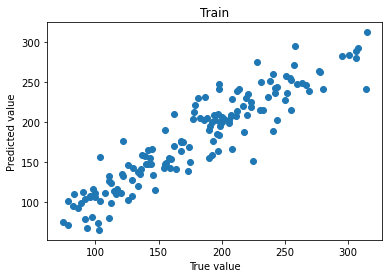

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9475696051120758
MAE:  19.62319765625
MSE:  421.9942346970815


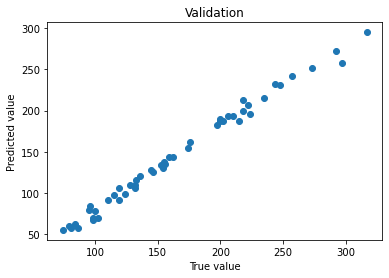

Epoch:  30
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1336385571956635
MAE:  13.092789680989583
MSE:  266.1383818074959


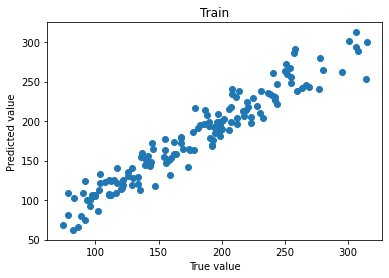

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.106525160074234
MAE:  11.357785449218749
MSE:  208.98223132115797


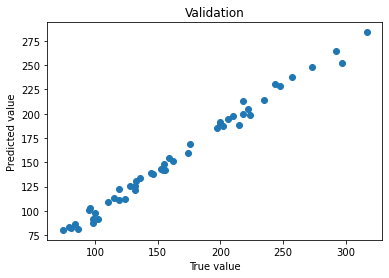

Epoch:  31
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1178654930988947
MAE:  14.240951171875
MSE:  322.95338733780954


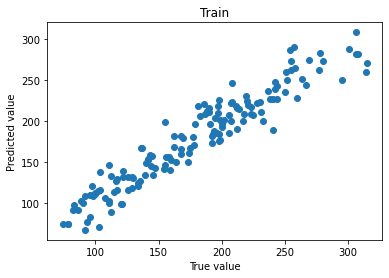

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1253035134077072
MAE:  9.937307714843753
MSE:  128.8623721113687


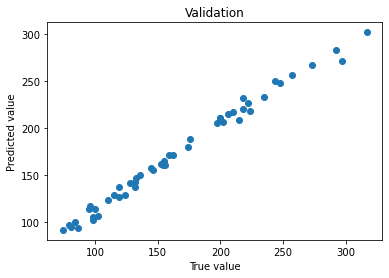

Epoch:  32
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1096061545610427
MAE:  14.536807552083333
MSE:  330.9387372596261


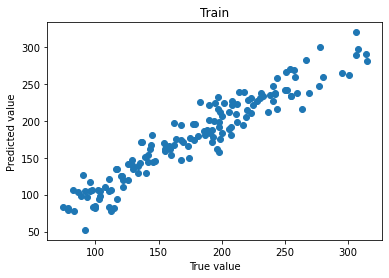

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.2330605471134186
MAE:  6.95856923828125
MSE:  75.55444686369754


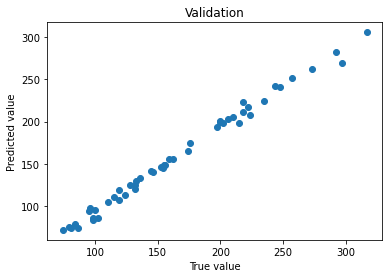

Epoch:  33
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0915857380628586
MAE:  13.78203671875
MSE:  287.6400892244809


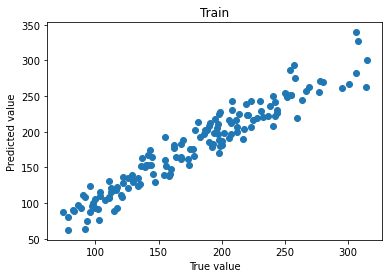

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8861128407716751
MAE:  14.416770605468749
MSE:  269.15698569587175


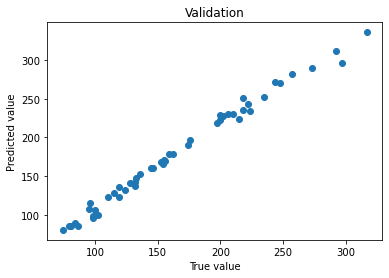

Epoch:  34
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.1083592023452122
MAE:  12.652299609375
MSE:  242.2243761881256


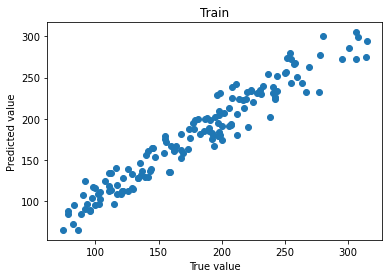

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8783792674541473
MAE:  17.083635351562496
MSE:  326.8696380458526


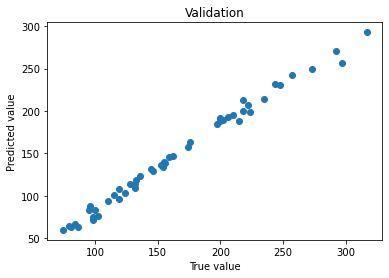

Epoch:  35
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.110162980357806
MAE:  11.85470869140625
MSE:  239.62150417551496


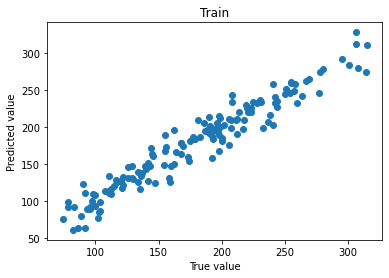

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8818816876411438
MAE:  6.0749135742187494
MSE:  60.57582982677884


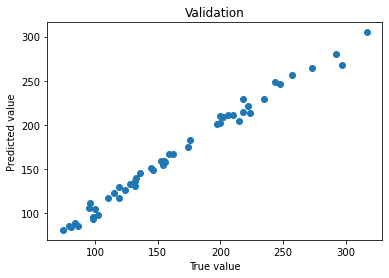

Epoch:  36
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0848163290818533
MAE:  14.094319726562498
MSE:  304.23118974658485


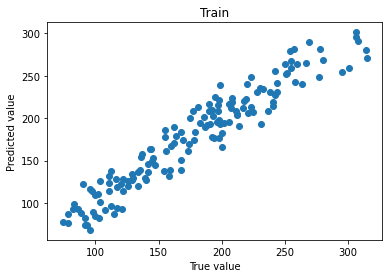

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0478891670703887
MAE:  10.497162109375001
MSE:  143.6478213856077


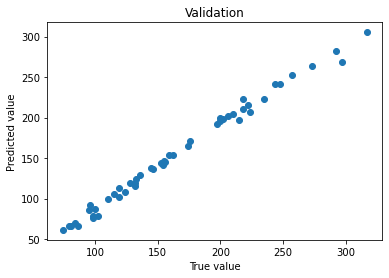

Epoch:  37
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0900870821873347
MAE:  12.446615201822915
MSE:  254.7529943480849


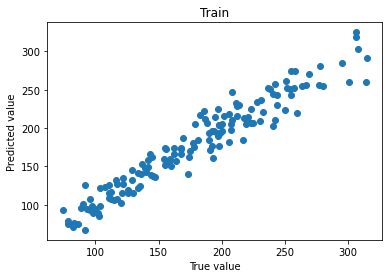

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0921724557876586
MAE:  10.429285644531252
MSE:  133.89106479948282


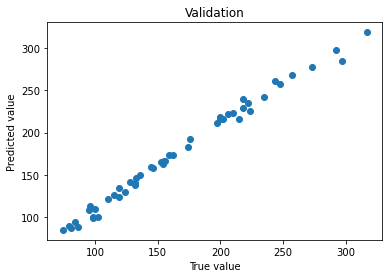

Epoch:  38
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0935275848706563
MAE:  10.484267903645835
MSE:  175.88702851889585


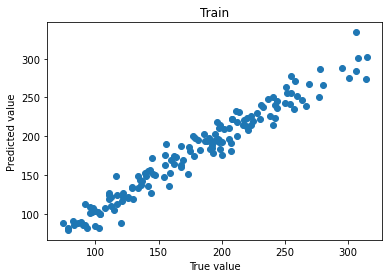

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8982526350021363
MAE:  11.8153720703125
MSE:  170.10399854278282


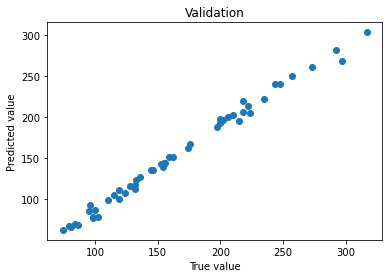

Epoch:  39
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0800571086009343
MAE:  10.104999544270836
MSE:  159.1679768051507


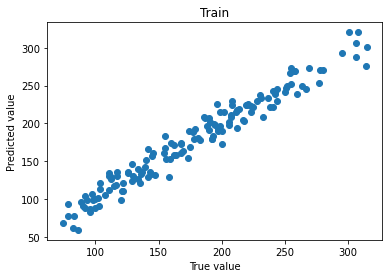

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8581333047151566
MAE:  4.7707877929687506
MSE:  37.098552665643226


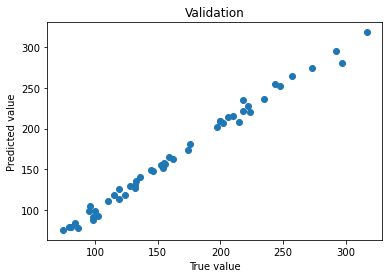

Epoch:  40
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0697673590977987
MAE:  9.815362923177084
MSE:  151.4576676828634


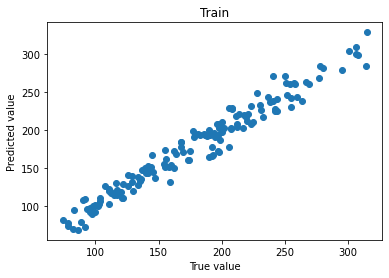

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8619670557975769
MAE:  5.1206184570312505
MSE:  49.76104443702461


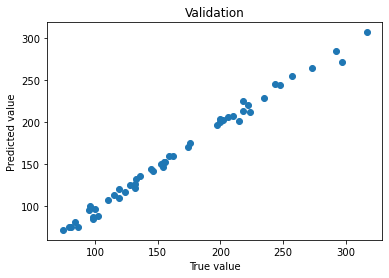

Epoch:  41
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0716910688082377
MAE:  10.811154069010417
MSE:  191.87537230165245


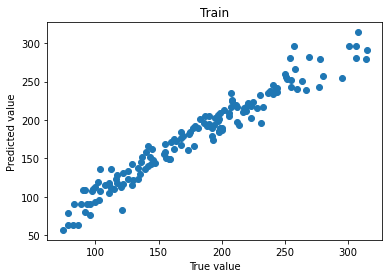

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9489094948768616
MAE:  4.6266007812500005
MSE:  42.396850297190646


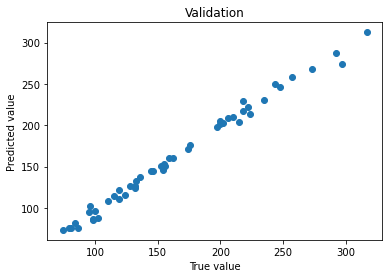

Epoch:  42
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0611485330263775
MAE:  9.9850568359375
MSE:  159.1490085937936


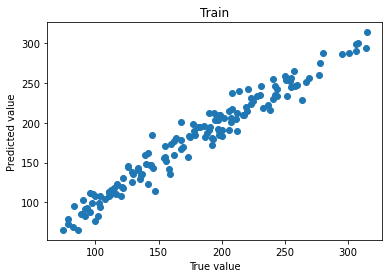

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.064424335360527
MAE:  4.433516894531249
MSE:  33.2494773195672


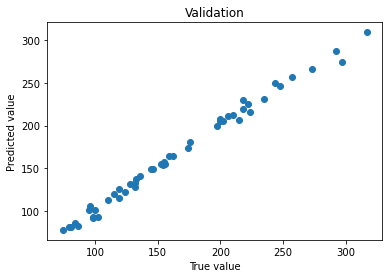

Epoch:  43
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0555083803335825
MAE:  10.246238346354165
MSE:  160.76842605907535


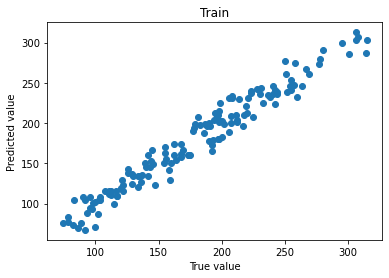

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9920655423402787
MAE:  8.02810654296875
MSE:  83.78596665103197


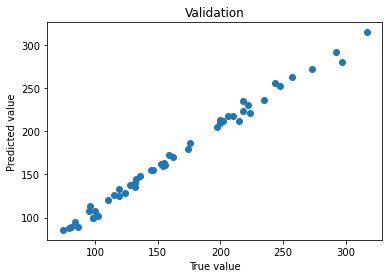

Epoch:  44
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0649272894859314
MAE:  9.744104427083332
MSE:  166.90892363089148


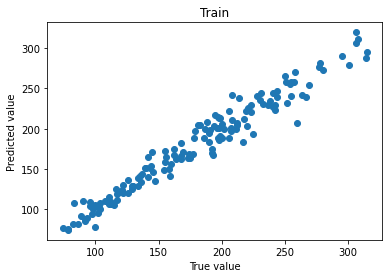

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9604041790962219
MAE:  12.606055175781252
MSE:  188.71025268862965


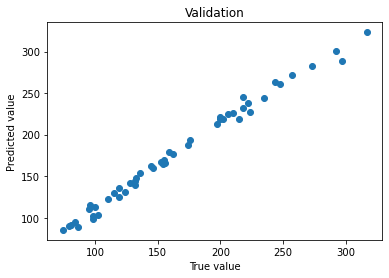

Epoch:  45
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0663839562733968
MAE:  9.797636588541666
MSE:  145.9936211704674


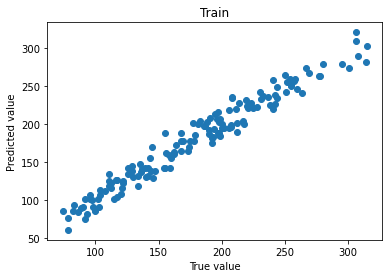

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9829682731628417
MAE:  7.397914257812501
MSE:  89.25920698346143


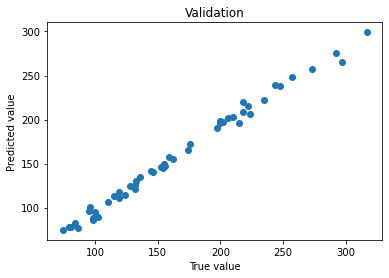

Epoch:  46
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0526215744018554
MAE:  8.186403808593749
MSE:  96.09806724191172


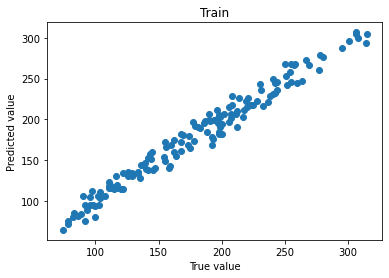

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.1698331117630005
MAE:  6.148968066406251
MSE:  53.35893042533159


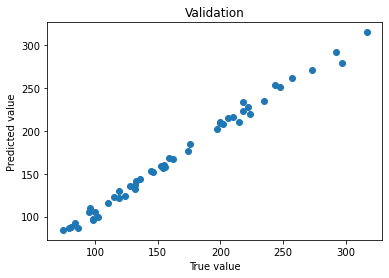

Epoch:  47
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0474096443255743
MAE:  8.236125325520833
MSE:  105.04473071325873


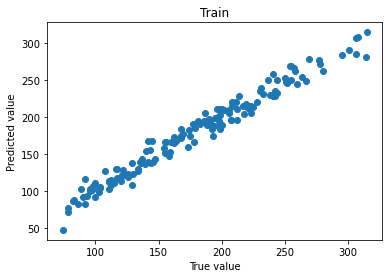

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.06820634663105
MAE:  7.376861621093747
MSE:  75.36175725249909


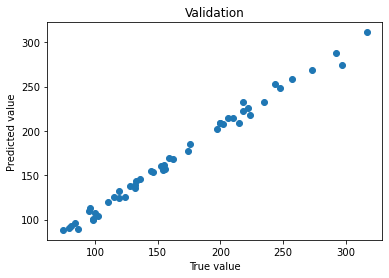

Epoch:  48
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0315926027297975
MAE:  9.214165657552085
MSE:  137.14012910606053


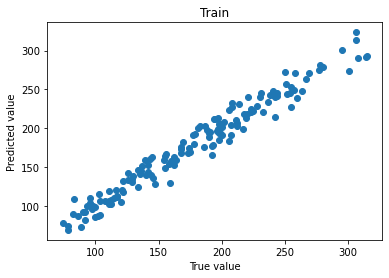

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9469520568847656
MAE:  5.034377929687501
MSE:  46.333008902384826


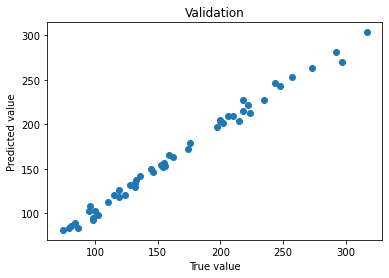

Epoch:  49
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0457880387703578
MAE:  8.616455826822918
MSE:  116.87549477987564


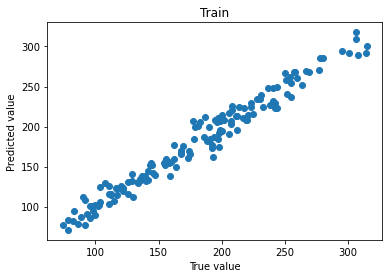

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0300386762619018
MAE:  6.660899902343748
MSE:  73.1799288265538


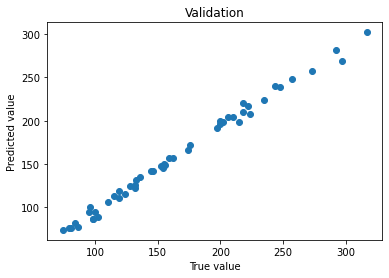

Epoch:  50
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0481804112593334
MAE:  8.483029850260417
MSE:  113.50420544681057


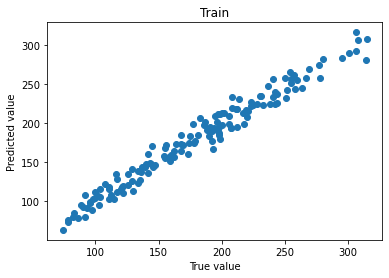

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9690158796310425
MAE:  4.3945373046875
MSE:  31.431608667170522


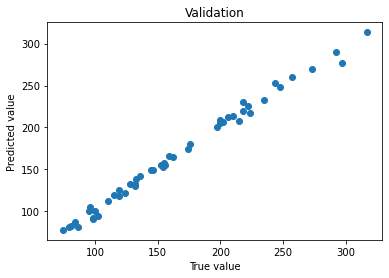

Epoch:  51
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0330417229731879
MAE:  8.152997688802083
MSE:  107.72375369990837


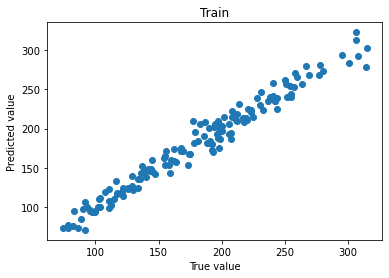

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.976275447010994
MAE:  5.260908203124997
MSE:  54.68976480394741


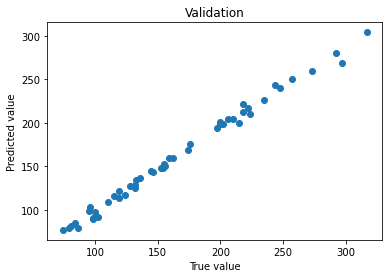

Epoch:  52
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0360633518298468
MAE:  8.149768554687498
MSE:  117.77172500302312


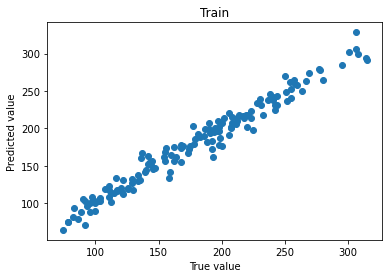

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9871036672592163
MAE:  4.40449775390625
MSE:  39.01968971205758


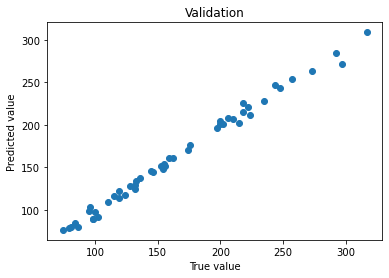

Epoch:  53
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.015026374856631
MAE:  6.447945963541667
MSE:  68.54045216335489


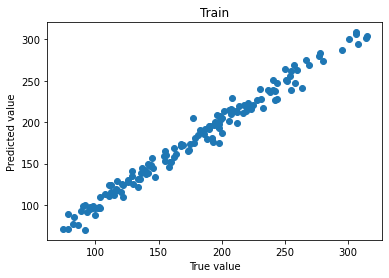

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.972549963593483
MAE:  4.449899511718751
MSE:  32.61953478531123


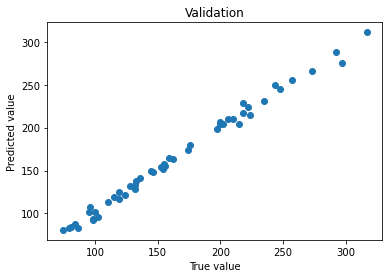

Epoch:  54
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0265622518459956
MAE:  9.577697363281251
MSE:  147.56200362678166


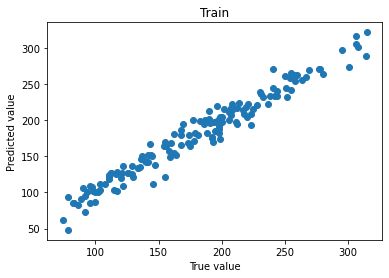

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9647696805000305
MAE:  4.5196212890625
MSE:  39.97109431831266


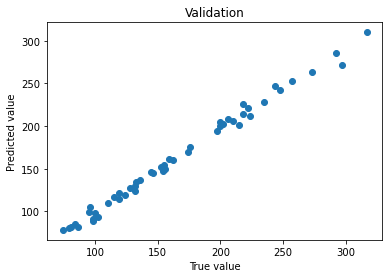

Epoch:  55
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0231982549031575
MAE:  7.996881282552082
MSE:  96.90277890681028


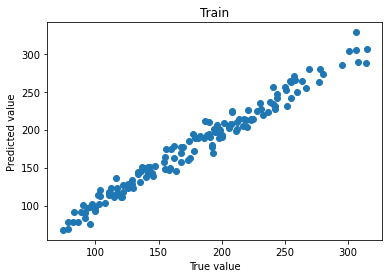

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8665157681703568
MAE:  5.077219042968748
MSE:  51.859194952112624


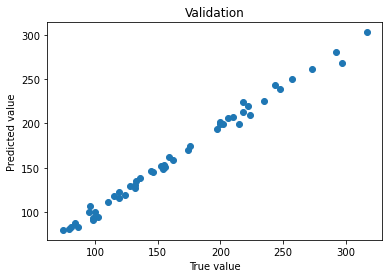

Epoch:  56
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0164889705181122
MAE:  7.347484863281251
MSE:  84.69536962528757


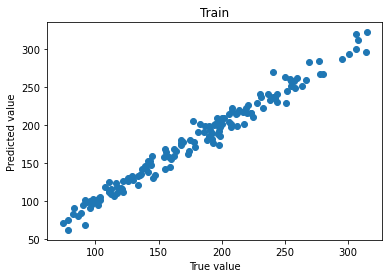

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.826990105509758
MAE:  4.959183300781251
MSE:  39.14168625819638


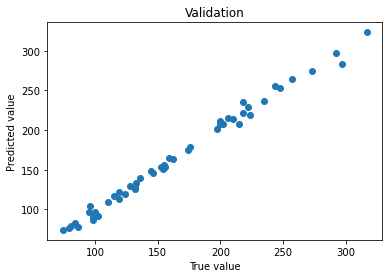

Epoch:  57
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0141333224376043
MAE:  6.492838216145833
MSE:  67.68096048836168


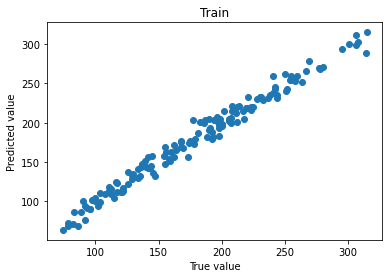

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9306793373823166
MAE:  4.061313085937502
MSE:  30.898612409832957


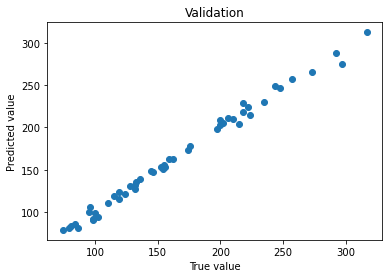

Epoch:  58
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0021985125541688
MAE:  6.4957955403645835
MSE:  66.2783449613754


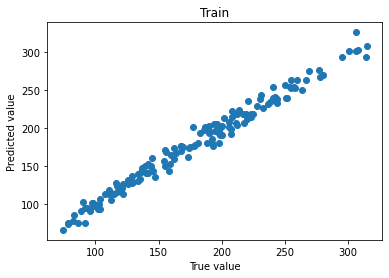

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  1.0792364889383317
MAE:  7.331033300781252
MSE:  77.31959592810776


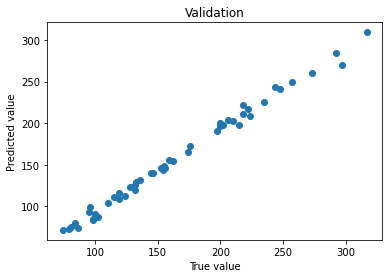

Epoch:  59
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0098987813790639
MAE:  6.917403255208333
MSE:  68.10968400409602


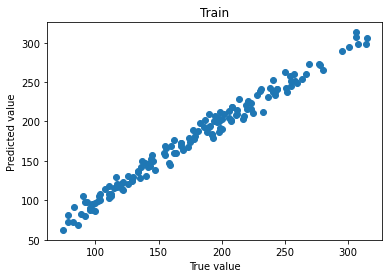

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9615010875463486
MAE:  5.0810777343749995
MSE:  45.83187462972924


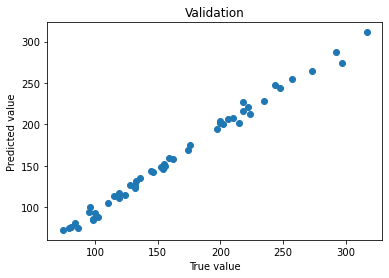

Epoch:  60
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  1.0037891771396001
MAE:  6.215431738281251
MSE:  58.27448909475121


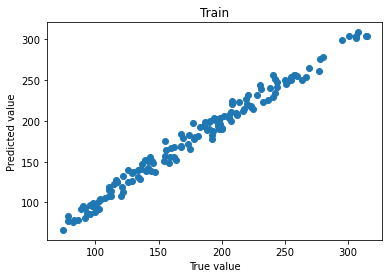

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.892560881972313
MAE:  4.814538964843748
MSE:  41.65352165819215


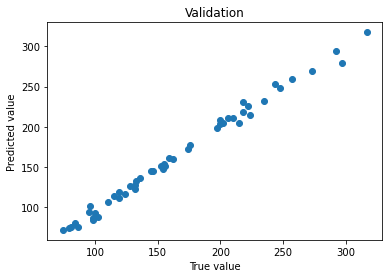

Epoch:  61
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9940073857704799
MAE:  6.549131054687501
MSE:  63.60325162017346


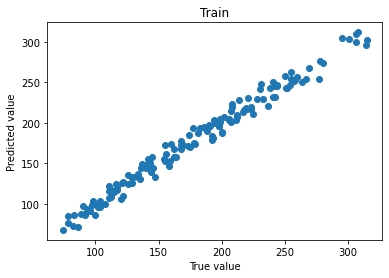

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9154193764925003
MAE:  5.5646574218749985
MSE:  44.90650695297145


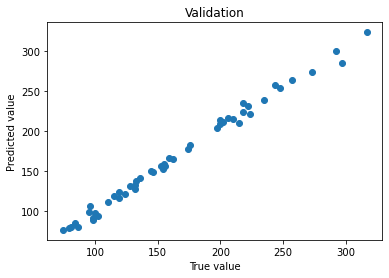

Epoch:  62
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9959078917900721
MAE:  6.564075748697916
MSE:  68.79704962431765


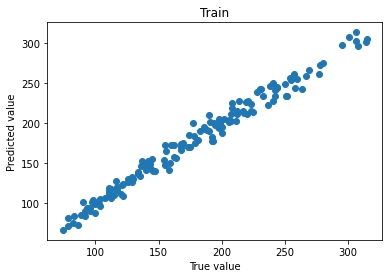

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8928868126869202
MAE:  4.614970898437502
MSE:  42.3442009447031


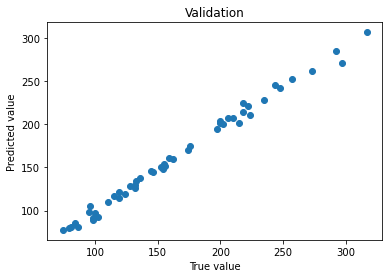

Epoch:  63
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9960262644290924
MAE:  5.934950065104166
MSE:  51.93907412425136


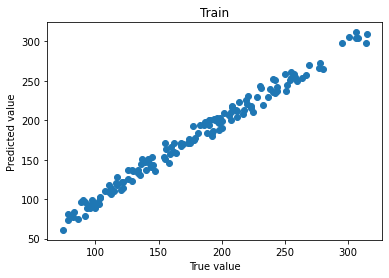

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.883185133934021
MAE:  4.2996591796875
MSE:  35.86288112535285


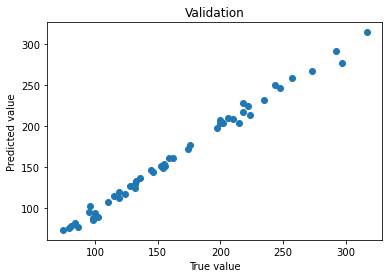

Epoch:  64
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9896486256519953
MAE:  6.028119010416666
MSE:  54.769984402535435


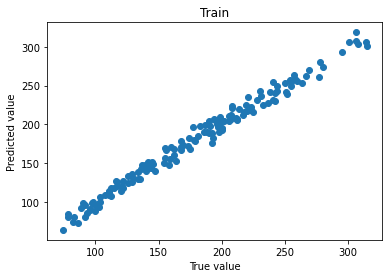

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9949858093261719
MAE:  4.487128417968751
MSE:  38.950376363938815


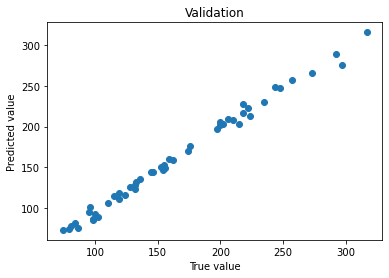

Epoch:  65
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9872199936707815
MAE:  5.632869856770832
MSE:  49.05842317239855


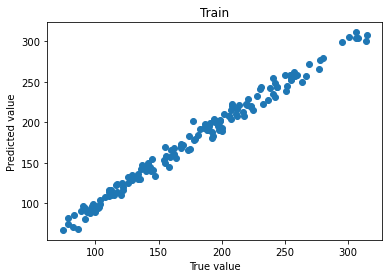

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.933840530514717
MAE:  4.091489746093749
MSE:  34.124772465431676


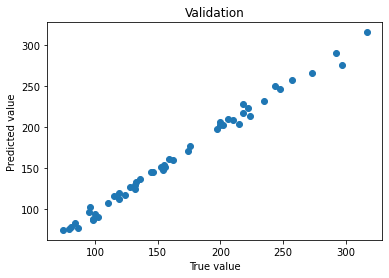

Epoch:  66
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9805231950680415
MAE:  5.580368457031251
MSE:  47.927217288846514


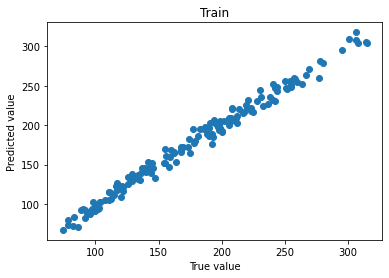

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9436801838874816
MAE:  3.8396088867187506
MSE:  30.37729961008694


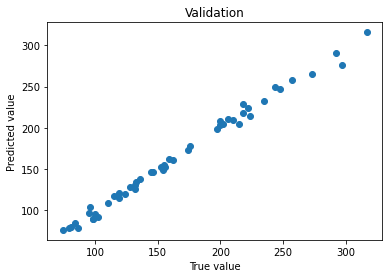

Epoch:  67
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9835680840412776
MAE:  5.478737662760417
MSE:  48.200269291202716


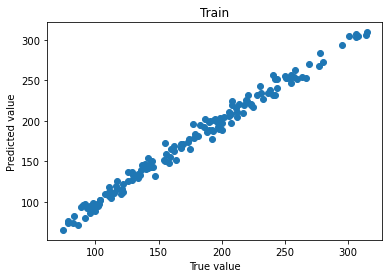

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8994218397140503
MAE:  3.91041162109375
MSE:  29.195502048889633


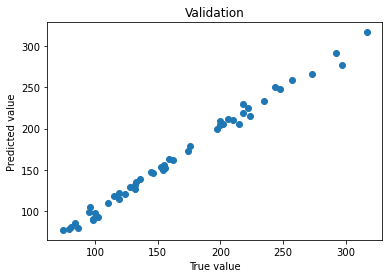

Epoch:  68
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9788444125652314
MAE:  5.663737141927084
MSE:  48.21395077608506


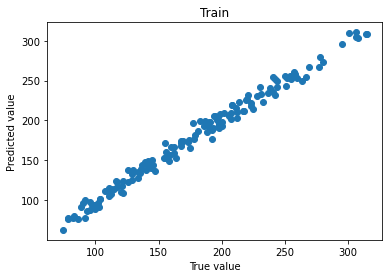

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.8948677408695221
MAE:  4.646274902343752
MSE:  40.59959850165225


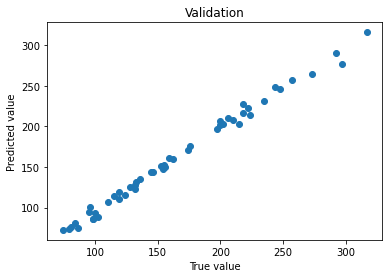

Epoch:  69
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9779210793972015
MAE:  5.414960286458333
MSE:  45.763405266459465


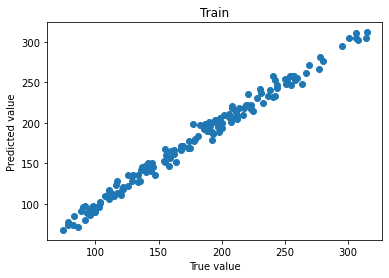

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9148848330974579
MAE:  4.12858896484375
MSE:  34.28771663746311


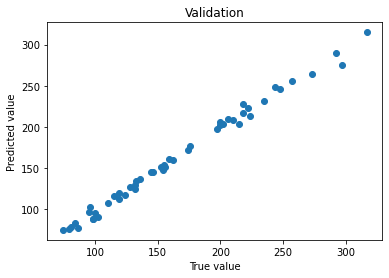

Epoch:  70
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9770834358533224
MAE:  5.287874837239583
MSE:  43.171199124674


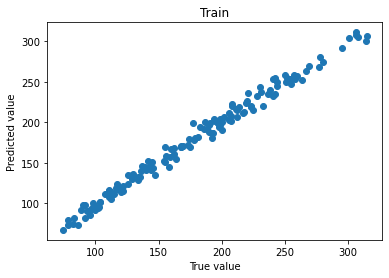

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9456511783599854
MAE:  3.863812988281251
MSE:  29.950543212162486


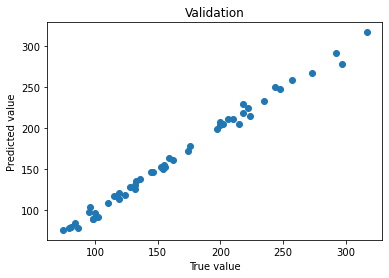

Epoch:  71
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9784946354230245
MAE:  5.230805208333333
MSE:  42.461709974516864


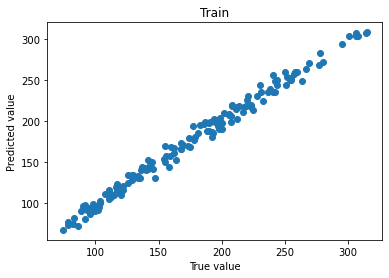

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9511640501022339
MAE:  3.8981839843749997
MSE:  30.7496039314575


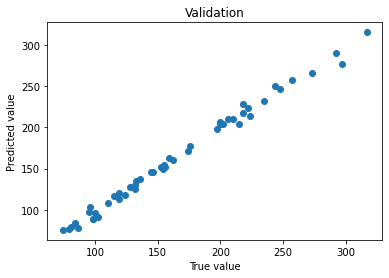

Epoch:  72
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9782906246185302
MAE:  4.910430175781251
MSE:  36.936264158383224


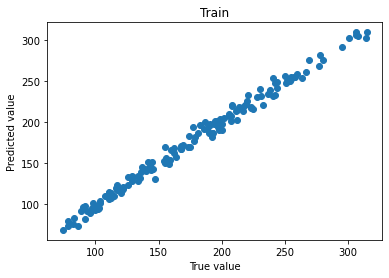

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9432706356048584
MAE:  3.8376129882812484
MSE:  29.409159176544666


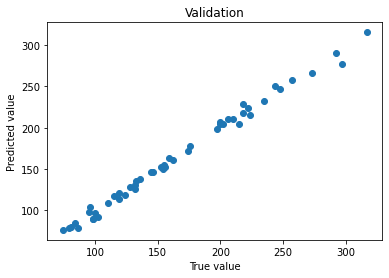

Epoch:  73
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9771574399868648
MAE:  4.955445963541668
MSE:  40.13624003010339


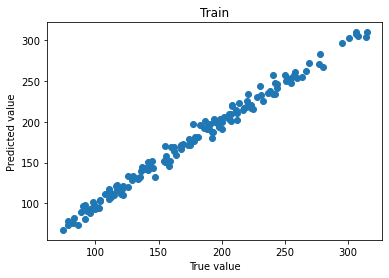

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9393036979436874
MAE:  3.85387705078125
MSE:  29.007787395903115


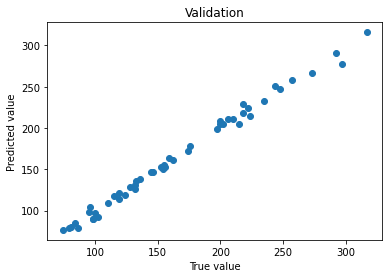

Epoch:  74
Training: 


<ipython-input-5-e9f355f54ba0>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model_nas.parameters(), 5)



Mean Loss:  0.9721748266617457
MAE:  4.815089420572918
MSE:  38.18553249847048


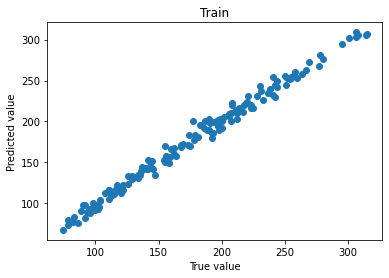

Validation: 


<ipython-input-5-e9f355f54ba0>:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True).cuda()
<ipython-input-5-e9f355f54ba0>:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()



Mean Loss:  0.9395920193195343
MAE:  3.8633584960937504
MSE:  28.770122540678507


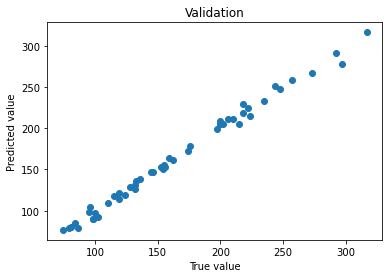

In [10]:
epochs = 75

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_nas, float(epochs))

for epoch in range(epochs):
    
    print("Epoch: ", epoch)
    
    train_nas(train_queue, model_nas, criterion_nas, optimizer_nas)
    validate_nas(valid_queue, model_nas, criterion_nas)
    
    scheduler.step()